In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.api.types import is_string_dtype, CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
#from keras.preprocessing.sequence import pad_sequences
#authors note, different version of Keras put pad_sequences in different places, if one doesn't work, please try the other
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.utils.data_utils import pad_sequences
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix


First step is to load economic regimes found through unsupervised training.

In [2]:
regimes = pd.read_parquet('quarterly_data/df_2020Q1.parquet')
regimes['labels']

usa            0
canada         0
europe         2
uk             0
australia      0
brazil         1
india          1
switzerland    2
japan          2
south korea    0
Name: labels, dtype: int32

In [3]:
countries = regimes[regimes['labels'] == 0].index.tolist()

In [4]:
import re

dfs = []

# Iterate over the countries
for country in countries:
    # Read the Parquet file into a DataFrame
    if country == 'uk':
        country = 'england'
    if country == 'south korea':
        country = 'korea'
    df = pd.read_parquet(f"fed_statements2/{country}.parquet")
    df = df.map(lambda x: re.sub(r'[^a-zA-Z0-9\s]|[\n]', '', str(x)) if isinstance(x, str) else x)
    
    # Add the DataFrame to the list
    dfs.append(df)

# Concatenate all the DataFrames along the row axis
data = pd.concat(dfs, axis=0)

In [5]:
data = data.sort_index(ascending=True)

In [6]:
from datetime import datetime, timedelta, time

# Create a copy of your DataFrame to avoid modifying the original data
data_adjusted = data.copy()

# Group by date and check for multiple entries per day
counts = data_adjusted.groupby(data_adjusted.index.normalize()).count()

# Get dates with more than one entry
duplicate_dates = counts[counts > 1].index

# Loop over duplicate dates and adjust the timestamps
for date in duplicate_dates:
    # Get the entries for this date
    entries = data_adjusted[data_adjusted.index.normalize() == date]
    
    # Generate new timestamps by adding a day for each subsequent entry
    new_timestamps = [pd.Timestamp(date + timedelta(days=i)) for i in range(len(entries))]
    
    # Update the index for the entries of this date
    data_adjusted.loc[data_adjusted.index.normalize() == date, 'index'] = new_timestamps

# Set the new index
data_adjusted.set_index('index', inplace=True)


In [7]:
target = pd.read_parquet("data/bonds.parquet")

In [8]:
target_resampled = target['usa'].diff().resample('D').interpolate(method='polynomial', order=2)
# Shift the DataFrame so we are predicting out in time
target_shifted = target_resampled.shift(30)


In [9]:
data_adjusted = data_adjusted.loc[~data_adjusted.index.duplicated(keep='first')]
data_adjusted.shape

(97, 1)

In [10]:
print(target_shifted.index.duplicated().sum())
print(data_adjusted.index.duplicated().sum())


0
0


In [11]:
# Get the common indices
common_indices = target_shifted.index.intersection(data_adjusted.index)

# Select the data from target_shifted and data_adjusted where the index is in common_indices
target_shifted = target_shifted.loc[common_indices]
data_adjusted = data_adjusted.loc[common_indices]



In [12]:
target_shifted.shape

(93,)

In [13]:
data_adjusted.columns

Index(['content'], dtype='object')

In [14]:
target_shifted.head()

2019-09-25         NaN
2019-10-01   -0.400000
2019-11-13    0.166744
2019-11-26    0.100563
2020-02-06    0.065905
Name: usa, dtype: float64

In [15]:
stop_words = set(stopwords.words('english'))

# Assuming df['content'] is a series of strings
sentences = data_adjusted['content'].tolist() #.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words)).tolist()


train word vectors

In [16]:
# Word2Vec
word2vec = Word2Vec(sentences, vector_size=240, window=5, min_count=1, workers=4)
word2vec.train(sentences, total_examples=len(sentences), epochs=10)

(3471638, 17186580)

In [17]:
word_vectors = word2vec.wv.vectors
# Create a word-to-index dictionary
word_to_index = {word: i for i, word in enumerate(word2vec.wv.index_to_key)}

# Create an embedding matrix
embedding_matrix = np.zeros((len(word_to_index) + 1, word2vec.vector_size))
for word, i in word_to_index.items():
    embedding_matrix[i] = word2vec.wv[word]


In [18]:
# Define variables
#taken from lesson 2.19
# Max number of words
vocab_size = 5000
# Word Vector dimension
embedding_dim = 64
# Max length of the sequence
max_length = 1000
# Where to chop off the seq
trunc_type = 'post'
# Where to put padding
padding_type = 'post'
#standard oov token convention
oov_token = '<OOV>'

In [19]:
# Word2Vec => tokenize my words to prep for LSTM
tokenizer = Tokenizer() #num_words=vocab_size, oov_token = oov_token
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
words = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

# Prepare target variable (freedom scores)

print(words.shape)
print(target_shifted.shape)


(93, 1000)
(93,)


Create target column

In [20]:
target_shifted=target_shifted.fillna(0)

In [21]:
def expand_features(full_array, window=10):

    n_features = full_array.shape[1]
    
    expanded_features = np.zeros((full_array.shape[0], n_features * window))
    for feature_idx in range(n_features):
        # For each time step in the window
        for lag in range(window):
            # Shift the data
            shifted_data = np.roll(full_array[:, feature_idx], lag)
            # Set the first 'lag' values to zero
            shifted_data[:lag] = 0
            # Store it in the expanded features
            expanded_features[:, feature_idx*window + lag] = shifted_data
            
    return expanded_features

In [22]:
expanded_data = expand_features(words, 10)

In [23]:
from tensorflow.keras.layers import Bidirectional
from keras.layers import Dropout

In [24]:

reg = Sequential()
reg.add(Embedding(input_dim=len(word_to_index) + 1, output_dim=word2vec.vector_size, weights=[embedding_matrix]))
reg.add(Bidirectional(LSTM(64, return_sequences = True)))
reg.add(Dropout(0.25))
reg.add(Bidirectional(LSTM(64, return_sequences = True)))
reg.add(Dropout(0.25))
reg.add(Bidirectional(LSTM(32)))
reg.add(Dropout(0.25))
reg.add(Dense(1))  # No activation function for regression

# Compile the model with gradient clipping
opt = Adam(clipvalue=0.5)
reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])  # Mean squared error for regression


In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [26]:
history = reg.fit(expanded_data, target_shifted.values, epochs=6, validation_split=0.2, batch_size=20, verbose=1)
reg.save('models/reg_lstm.h5')

Epoch 1/6


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/embedding/embedding_lookup' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue
      await self.process_one()
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 518, in process_one
      await dispatch(*args)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell
      await result
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 766, in execute_request
      reply_content = await reply_content
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_8336\2237236139.py", line 1, in <module>
      history = reg.fit(expanded_data, target_shifted.values, epochs=6, validation_split=0.2, batch_size=20, verbose=1)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential/embedding/embedding_lookup'
indices[12,5002] = 294 is not in [0, 65)
	 [[{{node sequential/embedding/embedding_lookup}}]] [Op:__inference_train_function_15667]

1/1 [==============================] - 28s 28s/step


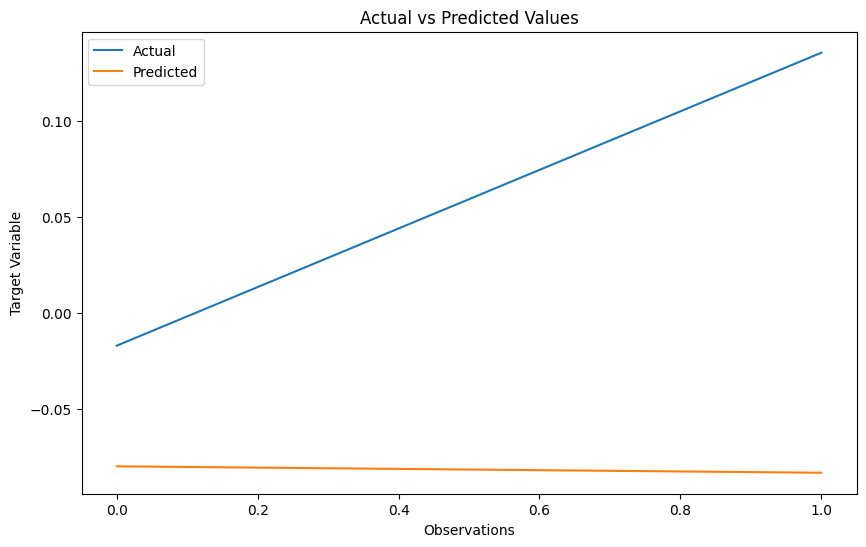

In [ ]:
from tensorflow.keras.models import load_model
# Load the model
model = load_model('models/us_reg_lstm.h5')

# Now the model is ready to use
predictions = model.predict(expanded_data)
# Generate predictions

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(target_shifted_selected.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Observations')
plt.ylabel('Target Variable')
plt.legend()
plt.show()


This is my classifier version used for training data when characterized by regime rather than numeric outputs

clf = Sequential()
clf.add(Embedding(input_dim=len(word_to_index) + 1, output_dim=word2vec.vector_size, weights=[embedding_matrix]))
clf.add(Bidirectional(LSTM(64, return_sequences = True)))
clf.add(Bidirectional(LSTM(32)))
clf.add(Dense(1, activation = 'sigmoid'))

# Compile the model with gradient clipping
opt = Adam(clipvalue=0.5)
clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Get the embeddings from the embedding layer
embeddings = reg.layers[0].get_weights()[0]

# Create a dictionary to map indices to words
word_to_index = tokenizer.word_index
index_to_word = {v: k for k, v in word_to_index.items()}

# Now you can get the embedding of a word like this:
word = "inflation"
word_embedding = embeddings[word_to_index[word]]

In [ ]:
word_embedding

array([ 0.3197837 ,  1.3196462 , -0.13536258,  0.8558886 ,  0.02217133,
        0.9029529 , -0.33944437, -0.39216486,  0.69603735, -0.22308737,
        1.2183967 ,  0.85914123,  0.81396884, -1.0701463 ,  1.0599334 ,
       -0.5449275 ,  0.45136854,  0.11346404, -0.92609113, -0.15696156,
        0.27834904, -0.05799539, -0.16527101,  0.27895895, -0.52025247,
       -0.84725416, -0.51876056,  0.14614095, -0.22882742, -0.81537306,
       -0.8643189 , -0.56057805, -0.64601827, -1.0938634 ,  0.46920165,
        1.6513169 , -0.46883613, -0.08800945, -0.16798688,  0.03972137,
       -0.5182455 ,  0.2769544 , -0.03944171,  0.37084734,  1.772079  ,
       -0.44043785,  0.4893732 ,  0.02369366,  0.03166683,  0.35054109,
        0.02601228,  0.57802457, -0.61721826, -0.00604655, -0.74447244,
       -0.23450482,  0.4911247 , -0.5973387 , -1.2636837 , -0.0570631 ,
        0.29914963,  2.086542  ,  0.39720142, -0.84857726, -0.5253244 ,
        0.17592032,  0.09428984,  0.2561064 , -0.39126232,  0.05

: 